# Version Info (V7)

- Using reward version V2 (+10 for not using, penalty proportional to extent of energy usage)
- Forecast info -> Hourly max vaues for 18 hrs instead of flag


- Radiation and heatflux considered as info in states

- Rerun of V5 on May, except for more iterations (2500)


1) remove radiation

2) revised reward function 

-> a. action-based smoothing (if preva~=a, -5, else +5)

3) look further into the future (20 hrs -> 70 hrs)


- Updates for V7

1) Energy consumption into states

In [2]:
import numpy as np
from policygradient_tf3 import PolicyGradientAgent
import matplotlib.pyplot as plt

# Echo server program
import socket
import random
import os
import shutil

In [3]:
def byteConv_forecastV3(rawBA, n_byte):
    
    tfd = np.zeros([1,n_byte])
    rw = 0
    
    for i in range(0,(n_byte)*2,2): # move by two steps
        if rawBA[i] < 200: # positive or negative, (positive)
            tfd[0,int(i/2)] = (rawBA[i]*256)+rawBA[i+1]
        else:
            tfd[0,int(i/2)] = -256*(256-rawBA[i])+rawBA[i+1]
    
    fd = tfd[0,:-1]
    fd = fd/400 # normalize by a factor of 40
    rw = tfd[0,n_byte-1]
    
    rfd = np.zeros([n_byte+(10-3)]) # basically 40. 30 for temp&forecast, 5 for hf. 5 for rad
    rfd[:len(fd)-2] = fd[:-2]
    rfd[len(fd):len(fd)+5] = fd[-2] # fill in heat flux 
    rfd[len(fd)+5:] = fd[-1] # fill in radiation
    
    
    return rfd, rw

In [4]:
path = 'pg/RV5_may_forecast_rad'
ID_='V01'

try:
    os.mkdir(path)
    os.mkdir('{0}/{1}'.format(path, 'checkpoint'))
except FileExistsError:
    msg = input('[FileExistsError] Will you remove directory? [Y/N]')
    if msg =='Y':
        shutil.rmtree(path)
        os.mkdir(path)
        os.mkdir('{0}/{1}'.format(path, 'checkpoint'))
    else:
        print('Please choose another ID.')
        assert 0 

[FileExistsError] Will you remove directory? [Y/N]Y


In [5]:
HOST = 'localhost' 
PORT = 50000 
s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
s.bind((HOST, PORT))
s.listen(1)
print("waiting for response from client at port ",PORT)
conn, addr = s.accept()
print('Connected by', addr)
print('Welcome')

md_size = 33

##


agent = PolicyGradientAgent(ALPHA=0.0005, input_dims=40, GAMMA=0.99,
                            n_actions=8, layer1_size=200, layer2_size=200, layer3_size=200,
                            chkpt_dir=path,ID=ID_)
# agent.load_checkpoint(1700)
score_history = []
score = 0
num_episodes = 1701
n_save = 100


while True:
    for i in range(num_episodes):
        print('episode: ', i,'score: ', score)
        done = False
        score = 0

        data = conn.recv(1024)

        if not data: 
            print('Connection terminated (out)')
            if i ==num_episodes:
                done=True
                break
        
        rd, rw = byteConv_forecastV3(data,md_size)

        observation = rd
        ts = 0
        
        while not done:
            action = agent.choose_action(observation)
            sa = int(action) # conversion to int to use .to_bytes() method
            send_action_temp = sa.to_bytes(1,'big') # conversion to bytes
            send_action=send_action_temp
            conn.sendall(send_action)

            data = conn.recv(1024)

            if not data: 
                print('Connection terminated (in)')
                if i == num_episodes:
                    done=True
                    break
                

            observation_, reward = byteConv_forecastV3(data, md_size)

            agent.store_transition(observation, action, reward)
            observation = observation_
            score += reward
            ts += 1
            
            if ts == 4463:
                done = True
        
        
        score_history.append(score)
        agent.learn()
        if i%n_save == 0:
            agent.save_checkpoint(i)


waiting for response from client at port  50000
Connected by ('127.0.0.1', 62109)
Welcome



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.dense instead.



episode:  0 score:  0
Model saved in file: 0
episode:  1 score:  -18221.0
episode:  2 score:  -18090.0
episode:  3 score:  -17550.0
episode:  4 score:  -17798.0
episode:  5 score:  -17069.0
episode:  6 score:  -16753.0
episode:  7 score:  -17377.0
episode:  8 score:  -17152.0
episode:  9 score:  -16725.0
episode:  10 score:  -15934.0
episode:  11 score:  -16148.0
episode:  12 score:  -15533.0
episode:  13 score:  -14920.0
episode:  14 score:  -14736.0
episode:  15 score:  -138

episode:  83 score:  336.0
episode:  84 score:  263.0
episode:  85 score:  171.0
episode:  86 score:  903.0
episode:  87 score:  1571.0
episode:  88 score:  1430.0
episode:  89 score:  1138.0
episode:  90 score:  1277.0
episode:  91 score:  1568.0
episode:  92 score:  1567.0
episode:  93 score:  1892.0
episode:  94 score:  1801.0
episode:  95 score:  1714.0
episode:  96 score:  1327.0
episode:  97 score:  1539.0
episode:  98 score:  1556.0
episode:  99 score:  1001.0
episode:  100 score:  1513.0
Model saved in file: 100
episode:  101 score:  1511.0
episode:  102 score:  1615.0
episode:  103 score:  1959.0
episode:  104 score:  2099.0
episode:  105 score:  1848.0
episode:  106 score:  1728.0
episode:  107 score:  2039.0
episode:  108 score:  1785.0
episode:  109 score:  1714.0
episode:  110 score:  2009.0
episode:  111 score:  2346.0
episode:  112 score:  2229.0
episode:  113 score:  2330.0
episode:  114 score:  2080.0
episode:  115 score:  2139.0
episode:  116 score:  1829.0
episode:  

episode:  364 score:  4174.0
episode:  365 score:  3737.0
episode:  366 score:  4197.0
episode:  367 score:  4560.0
episode:  368 score:  4896.0
episode:  369 score:  4937.0
episode:  370 score:  5099.0
episode:  371 score:  4709.0
episode:  372 score:  5007.0
episode:  373 score:  4772.0
episode:  374 score:  4371.0
episode:  375 score:  4590.0
episode:  376 score:  4726.0
episode:  377 score:  5029.0
episode:  378 score:  5164.0
episode:  379 score:  5085.0
episode:  380 score:  4967.0
episode:  381 score:  5111.0
episode:  382 score:  4981.0
episode:  383 score:  5058.0
episode:  384 score:  5036.0
episode:  385 score:  4975.0
episode:  386 score:  4920.0
episode:  387 score:  5044.0
episode:  388 score:  4987.0
episode:  389 score:  4963.0
episode:  390 score:  4850.0
episode:  391 score:  4830.0
episode:  392 score:  4881.0
episode:  393 score:  4112.0
episode:  394 score:  4219.0
episode:  395 score:  3895.0
episode:  396 score:  3960.0
episode:  397 score:  4150.0
episode:  398 

episode:  633 score:  5796.0
episode:  634 score:  5483.0
episode:  635 score:  5831.0
episode:  636 score:  6189.0
episode:  637 score:  6109.0
episode:  638 score:  6095.0
episode:  639 score:  6034.0
episode:  640 score:  5929.0
episode:  641 score:  5972.0
episode:  642 score:  6264.0
episode:  643 score:  6177.0
episode:  644 score:  6202.0
episode:  645 score:  6367.0
episode:  646 score:  6383.0
episode:  647 score:  6227.0
episode:  648 score:  6275.0
episode:  649 score:  5626.0
episode:  650 score:  5312.0
episode:  651 score:  5592.0
episode:  652 score:  5857.0
episode:  653 score:  6023.0
episode:  654 score:  5283.0
episode:  655 score:  5527.0
episode:  656 score:  6539.0
episode:  657 score:  5776.0
episode:  658 score:  5804.0
episode:  659 score:  5457.0
episode:  660 score:  6218.0
episode:  661 score:  5944.0
episode:  662 score:  5980.0
episode:  663 score:  6267.0
episode:  664 score:  5431.0
episode:  665 score:  6347.0
episode:  666 score:  6196.0
episode:  667 

episode:  913 score:  6819.0
episode:  914 score:  6702.0
episode:  915 score:  6625.0
episode:  916 score:  6965.0
episode:  917 score:  6392.0
episode:  918 score:  6790.0
episode:  919 score:  6676.0
episode:  920 score:  6599.0
episode:  921 score:  6301.0
episode:  922 score:  6480.0
episode:  923 score:  6082.0
episode:  924 score:  6168.0
episode:  925 score:  6027.0
episode:  926 score:  5866.0
episode:  927 score:  6197.0
episode:  928 score:  6134.0
episode:  929 score:  6290.0
episode:  930 score:  6511.0
episode:  931 score:  6504.0
episode:  932 score:  5585.0
episode:  933 score:  5323.0
episode:  934 score:  4937.0
episode:  935 score:  5532.0
episode:  936 score:  4552.0
episode:  937 score:  5706.0
episode:  938 score:  4836.0
episode:  939 score:  6336.0
episode:  940 score:  6325.0
episode:  941 score:  6787.0
episode:  942 score:  6622.0
episode:  943 score:  5997.0
episode:  944 score:  6372.0
episode:  945 score:  6318.0
episode:  946 score:  6542.0
episode:  947 

episode:  1188 score:  6616.0
episode:  1189 score:  6537.0
episode:  1190 score:  6740.0
episode:  1191 score:  6696.0
episode:  1192 score:  6749.0
episode:  1193 score:  6532.0
episode:  1194 score:  6945.0
episode:  1195 score:  6949.0
episode:  1196 score:  6891.0
episode:  1197 score:  6934.0
episode:  1198 score:  6714.0
episode:  1199 score:  6944.0
episode:  1200 score:  6980.0
Model saved in file: 1200
episode:  1201 score:  6876.0
episode:  1202 score:  6780.0
episode:  1203 score:  6094.0
episode:  1204 score:  6796.0
episode:  1205 score:  6896.0
episode:  1206 score:  5921.0
episode:  1207 score:  6336.0
episode:  1208 score:  5767.0
episode:  1209 score:  5986.0
episode:  1210 score:  4917.0
episode:  1211 score:  6141.0
episode:  1212 score:  6154.0
episode:  1213 score:  6585.0
episode:  1214 score:  6516.0
episode:  1215 score:  7045.0
episode:  1216 score:  6731.0
episode:  1217 score:  6634.0
episode:  1218 score:  6526.0
episode:  1219 score:  6726.0
episode:  1220

episode:  1459 score:  6865.0
episode:  1460 score:  6846.0
episode:  1461 score:  6848.0
episode:  1462 score:  6958.0
episode:  1463 score:  6964.0
episode:  1464 score:  7030.0
episode:  1465 score:  6578.0
episode:  1466 score:  6405.0
episode:  1467 score:  7053.0
episode:  1468 score:  6432.0
episode:  1469 score:  6864.0
episode:  1470 score:  6688.0
episode:  1471 score:  6424.0
episode:  1472 score:  6048.0
episode:  1473 score:  6098.0
episode:  1474 score:  5920.0
episode:  1475 score:  5868.0
episode:  1476 score:  5666.0
episode:  1477 score:  5436.0
episode:  1478 score:  5200.0
episode:  1479 score:  5064.0
episode:  1480 score:  5138.0
episode:  1481 score:  5142.0
episode:  1482 score:  4681.0
episode:  1483 score:  5023.0
episode:  1484 score:  5027.0
episode:  1485 score:  5068.0
episode:  1486 score:  5062.0
episode:  1487 score:  5212.0
episode:  1488 score:  5196.0
episode:  1489 score:  5163.0
episode:  1490 score:  5301.0
episode:  1491 score:  5333.0
episode:  

IndexError: index out of range

In [62]:
HOST = 'localhost' 
PORT = 50000 
s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
s.bind((HOST, PORT))
s.listen(1)
print("waiting for response from client at port ",PORT)
conn, addr = s.accept()
print('Connected by', addr)
print('Welcome')

md_size = 33

num_episodes = 3
agent.load_checkpoint(1700)



while True:
    for i in range(num_episodes):
        done = False

        data = conn.recv(1024)

        if not data: 
            print('Connection terminated (out)')
            if i ==num_episodes:
                done=True
                break
        
        rd, rw = byteConv_forecastV3(data,md_size)

        observation = rd
        ts = 0
        
        while not done:
            action = agent.choose_action(observation)
            sa = int(action) # conversion to int to use .to_bytes() method
            send_action_temp = sa.to_bytes(1,'big') # conversion to bytes
            send_action=send_action_temp
            conn.sendall(send_action)

            data = conn.recv(1024)

            if not data: 
                print('Connection terminated (in)')
                if i == num_episodes:
                    done=True
                    break
                

            observation_, reward = byteConv_forecastV3(data, md_size)
            observation = observation_
            ts += 1
            
            if ts == 4463:
                done = True
        

waiting for response from client at port  50000
Connected by ('127.0.0.1', 53040)
Welcome
...Loading checkpoint...
INFO:tensorflow:Restoring parameters from ./pg/RV5_may_forecast_rad/checkpoint/V01_1700
Connection terminated (out)


IndexError: index out of range

In [ ]:
observation_, reward = byteConv_forecastV2(data, md_size)


In [ ]:
print(tob)
print(observation)

In [ ]:
rd, rw = byteConv_forecast(data,md_size)

observation = rd

In [ ]:
data

In [ ]:
tob = observation.reshape(1, 25)
action = agent.choose_action(observation)

print(action)


In [ ]:
10%3

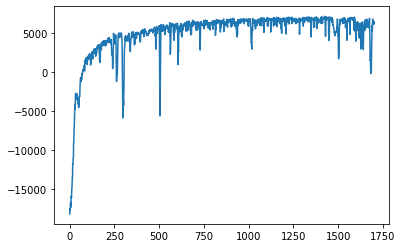

In [14]:
plt.figure()
plt.plot(score_history)
plt.show()

In [ ]:
observation

In [ ]:
data

In [ ]:
aa = 1



In [ ]:
send_action_temp

In [ ]:
observation_

In [ ]:
ts

In [ ]:
action

In [ ]:
type(action)

In [ ]:
bb = np.uint8(action)

In [ ]:
type(bb)

In [ ]:
dd = int(action)

In [ ]:
type(dd)

In [ ]:
djdj = dd.to_bytes(1,'big')

In [ ]:
print(djdj)

In [ ]:
cc = bb.to_bytes(1,'big')

In [ ]:
int.to_bytes?